In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## **Data cleaning and preparation**

In [12]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [3]:
!wget $data

--2021-10-15 14:37:10--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: 'CreditScoring.csv.1'

     0K .......... .......... .......... .......... .......... 28% 2.09M 0s
    50K .......... .......... .......... .......... .......... 56% 4.79M 0s
   100K .......... .......... .......... .......... .......... 84% 13.9M 0s
   150K .......... .......... ........                        100%  142M=0.04s

2021-10-15 14:37:10 (4.68 MB/s) - 'CreditScoring.csv.1' saved [182489/182489]



In [13]:
df = pd.read_csv(data)

In [14]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [15]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [16]:
status_values = {
    1: 'ok', 
    2: 'default', 
    0: 'unk'}
df.status = df.status.map(status_values)

In [17]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [18]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [19]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
df_full_train, df_test = train_test_split(df, test_size=.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=.25, random_state=11)

In [22]:
y_train = (df_train.status == 'default').astype(int).values
y_val = (df_val.status == 'default').astype(int).values
y_test = (df_test.status == 'default').astype(int).values

In [23]:
del df_train['status']
del df_val['status']
del df_test['status']

## **Decision Trees**

In [24]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [25]:
xi = df_train.iloc[0].to_dict()

In [26]:
assess_risk(xi)

'ok'

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [28]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [29]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [30]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [31]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [32]:
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val: ', auc)

y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train; ', auc)

val:  0.7389079944782155
train;  0.7761016984958594


In [33]:
from sklearn.tree import export_text

In [34]:
print(export_text(dt, feature_names = dv.get_feature_names()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



## **Decision Tree Learning Algorithm**

In [35]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])

In [36]:
df_example.sort_values('assets')

Ts = [2000, 3000, 4000, 5000, 8000]

In [37]:
for T in Ts:
    print(T)
    df_left = df_example[df_example. assets <= T]
    df_right = df_example[df_example.assets > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))
    print()

2000
NumExpr defaulting to 8 threads.


,assets,status
1,2000,default
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


ok         0.8
default    0.2
Name: status, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,status
0,8000,default
6,9000,ok


default    0.5
ok         0.5
Name: status, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,status
6,9000,ok


ok    1.0
Name: status, dtype: float64



In [38]:
T = 4000
df_left = df_example[df_example. assets <= T]
df_right = df_example[df_example.assets > T]
display(df_left)
print(df_left.status.value_counts(normalize=True))
display(df_right)
print(df_right.status.value_counts(normalize=True))


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64


In [39]:
df_example.debt.sort_values()

AttributeError: 'DataFrame' object has no attribute 'debt'

In [40]:
thresholds = {
    'assets': [2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000, 500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])

In [41]:
for feature, T in thresholds.items():
    print('#####################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('#####################')

#####################
assets
2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.8
default    0.2
Name: status, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


ok         0.75
default    0.25
Name: status, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


default    0.5
ok         0.5
Name: status, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64

#####################
#####################
debt
2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default


default    1.0
Name: status, dtype: float64

3000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,debt,status


Series([], Name: status, dtype: float64)

4000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,debt,status


Series([], Name: status, dtype: float64)

5000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,debt,status


Series([], Name: status, dtype: float64)

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,debt,status


Series([], Name: status, dtype: float64)

#####################


## **Decision tree parameter tuning**

- Select max_depth and min_samples_leaf

In [42]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %3f' % (d, auc))

   1 -> 0.605864
   2 -> 0.668526
   3 -> 0.738908
   4 -> 0.761283
   5 -> 0.766938
   6 -> 0.756781
  10 -> 0.694086
  15 -> 0.667379
  20 -> 0.661470
None -> 0.649933


In [43]:
scores = []
for d in [4, 5, 6, 7, 10, 15, 20, None]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)
    
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
    
        scores.append((d, s, auc))
        #print('%4s d, %3d s -> %3f' % (d,s, auc))

In [44]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'auc'])

In [45]:
df_scores.sort_values(by='auc', ascending=False)

,max_depth,min_samples_leaf,auc
40,10.0,15,0.790281
49,15.0,15,0.788619
67,NaN,15,0.787887
58,20.0,15,0.785407
22,6.0,15,0.785080
...,...,...,...
36,10.0,1,0.677866
55,20.0,2,0.672886
63,NaN,1,0.667530
45,15.0,1,0.663395


In [46]:

df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc                                                 
max_depth           NaN   4.0    5.0    6.0    7.0    10.0   15.0   20.0
min_samples_leaf                                                        
1                 0.668  0.761  0.766  0.756  0.748  0.678  0.663  0.661
2                 0.694  0.761  0.766  0.754  0.743  0.716  0.691  0.673
5                 0.719  0.761  0.768  0.762  0.758  0.729  0.716  0.715
10                0.762  0.761  0.762  0.778  0.765  0.766  0.766  0.759
15                0.788  0.764  0.773  0.785  0.779  0.790  0.789  0.785
20                0.785  0.761  0.774  0.774  0.779  0.784  0.781  0.782
100               0.779  0.756  0.763  0.776  0.780  0.780  0.779  0.779
200               0.768  0.747  0.759  0.768  0.768  0.768  0.768  0.768
500               0.680  0.680  0.680  0.680  0.680  0.680  0.680  0.680

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

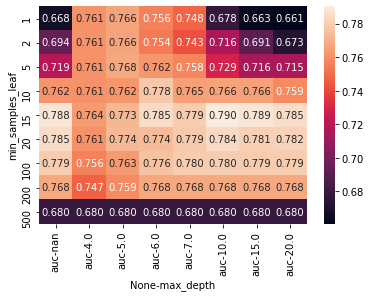

In [47]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [48]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

## **Random Forest**

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [51]:
y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
auc

0.7744726453706618

In [52]:
rf.predict_proba(X_val[[0]])

array([[0.9, 0.1]])

In [53]:
scores = []
for n in range(10,201,10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

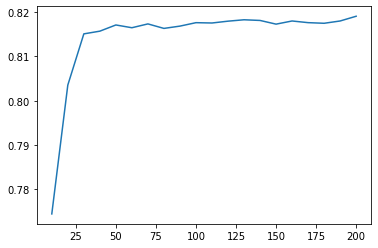

In [54]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
plt.plot(df_scores.n_estimators, df_scores.auc)

In [55]:
scores = []
for d in [5, 10, 15]:
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n, random_state=1)
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
    
        scores.append((d, n, auc))

In [56]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc'])

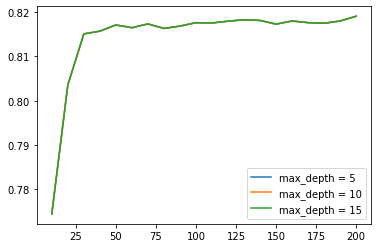

In [57]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='max_depth = %s' % d)
plt.legend()

In [58]:
scores = []
max_depth = 10
for s in [1, 3, 5, 10, 50]:
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=s, random_state=1)
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
    
        scores.append((s, n, auc))

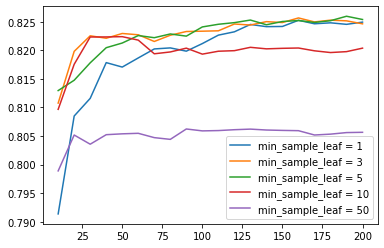

In [59]:
df_scores = pd.DataFrame(scores, columns=['min_sample_leaf', 'n_estimators', 'auc'])
for s in [1, 3, 5, 10, 50]:
    df_subset = df_scores[df_scores.min_sample_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='min_sample_leaf = %s' % s)
plt.legend()

In [60]:
min_samples_leaf = 3

In [61]:
rf = RandomForestClassifier(n_estimators=100,
                           max_depth=max_depth,
                           min_samples_leaf=min_samples_leaf,
                           random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_jobs=-1,
                       random_state=1)

## **Gradient Boosting and XGBoost**

In [9]:
import pip
pip.main(['install', 'xgboost'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


  Using cached xgboost-1.4.2-py3-none-win_amd64.whl (97.8 MB)


0

In [10]:
import xgboost as xgb

In [63]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [68]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1, 
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

[21:11:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [69]:
y_pred = model.predict(dval)

In [70]:
roc_auc_score(y_val, y_pred)

0.8152745150274878

In [71]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [94]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1, 
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=200, verbose_eval=5)

In [77]:
s = output.stdout

In [80]:
line = s.split('\n')[0]

In [81]:
num_iter, train_auc, val_auc = line.split('\t')

In [82]:
int(num_iter.strip('[]'))

0

In [84]:
float(train_auc.split(':')[1])

0.863

In [97]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [98]:
df_score = parse_xgb_output(output)
df_score

,num_iter,train_auc,val_auc
0,0,0.86300,0.76818
1,5,0.92863,0.80606
2,10,0.95002,0.81558
3,15,0.96558,0.81680
4,20,0.97316,0.81775
5,25,0.98174,0.81878
6,30,0.98772,0.81788
7,35,0.99180,0.81510
8,40,0.99456,0.81387
9,45,0.99596,0.81462


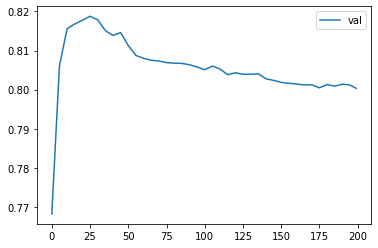

In [100]:
#plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

## **XGBoost Parameter Tuning**

In [112]:
scores = {}

In [121]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1, 
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=200, verbose_eval=5)

In [122]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

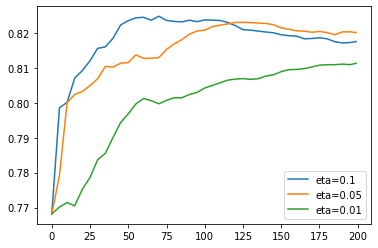

In [126]:
etas = ['eta=0.1', 'eta=0.05', 'eta=0.01']
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)
plt.legend()

In [135]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1, 
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=200, verbose_eval=5)

In [142]:
scores = {}

In [136]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)

In [139]:
del scores['max_depth=10']

(0.8, 0.84)

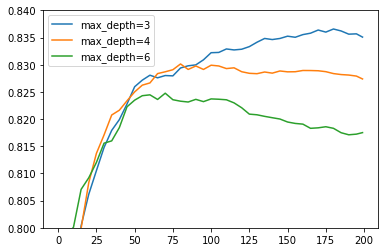

In [141]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)
plt.legend()
plt.ylim(0.8, 0.84)

In [147]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 30, 
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=200, verbose_eval=5)

In [148]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)

(0.82, 0.84)

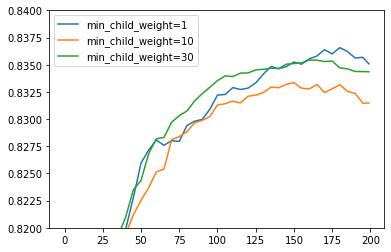

In [152]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)
plt.legend()
plt.ylim(0.82, 0.84)

In [158]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 30, 
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

## **Choosing the Final Model**

In [154]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [160]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7848562640769174

In [157]:
rf = RandomForestClassifier(n_estimators=200,
                           max_depth=10,
                           min_samples_leaf=3,
                           random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       n_jobs=-1, random_state=1)

In [165]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [159]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 30, 
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [166]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8354877576227264

In [170]:
df_full_train = df_full_train.reset_index(drop=True)
df_full_train

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,22,owner,48,48,married,no,fixed,60,110.0,3000.0,0.0,1000,1460
1,default,8,other,60,41,married,no,freelance,45,62.0,0.0,0.0,1800,2101
2,ok,2,parents,36,19,married,no,fixed,35,162.0,4000.0,100.0,400,570
3,ok,1,owner,12,61,married,no,others,45,103.0,20000.0,0.0,300,650
4,ok,13,owner,60,27,married,no,fixed,35,253.0,7000.0,0.0,1060,1750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3558,default,4,owner,60,47,married,no,freelance,75,0.0,13500.0,0.0,1900,1976
3559,ok,2,rent,60,28,single,no,fixed,45,101.0,0.0,0.0,1300,1333
3560,ok,2,parents,36,25,single,no,fixed,35,110.0,0.0,0.0,500,1200
3561,ok,4,other,60,25,single,no,fixed,35,162.0,0.0,0.0,1800,2999


In [173]:
y_full_train = (df_full_train.status == 'default').astype(int).values

In [174]:
del df_full_train['status']

In [177]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [178]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=dv.get_feature_names())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names())

In [179]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 30, 
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [180]:
y_pred = model.predict(dtest)

In [181]:
roc_auc_score(y_test, y_pred)

0.8302929964322369